# Prompt

Using a dataset of your own, explore the data utilizing multiple cross-validation techniques. Choose the most appropriate cross-validation technique for your data.

In your initial post, describe your data, state which cross-validation technique you used, and explain your rationale for deciding on which cross-validation technique was the most appropriate for your specific dataset.

# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.feature_selection import SequentialFeatureSelector
import plotly.express as px

np.random.seed(1234)

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = pd.read_csv("./data/housing.csv")
display(df.head())
display(df.info())
df.dropna(inplace=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

# Drop Outliers

In [4]:
df = df.query("median_house_value < 500e3")
df = df.query("median_income < 9")
df = df.query("households < 1800")

# Problem Statement and Model Setup

## Problem Statement

The data set contains the target feature - median_house_value - and we wish to develop a model from the other features to predict this feature.  

Take 2: using the diabetes data set, make BMI the target feature. I realize the objective of this data set is predicting diabetes, not BMI, but I was interested in a numeric, not categorical feature, so I somewhat arbitrarily decided to check if I could predict BMI given the other features.

## Model Setup

We will establish a pipeline of:
- Polynomial features
- Standardization
- Ridge Regression

and declare the hyperparameter of interest to be the alpha parameter for ridge.

We also saw that polynomial performance (more so on higher-order models) suffered unless the data was scaled prior to doing the polynomial feature transformation, so we will scale the data up front once.

### Defining Target and Regression Features

In [5]:
target_feature = "median_house_value"

['median_house_value',
 ['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income']]

In [ ]:
numeric_features = df.columns[df.dtypes != "object"].to_list()
numeric_features.remove(target_feature)
numeric_features

### Standardize

In [6]:
df_zscores = df.copy(deep=True)
df_zscores[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
df_zscores.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-1.325064,1.029960,0.998679,-0.975790,-1.177920,-1.199206,-1.192836,3.096571,452600.0,NEAR BAY
1,-1.320079,1.020670,-0.612695,2.850856,1.843797,1.190767,2.278165,3.080832,358500.0,NEAR BAY
2,-1.330050,1.016025,1.884935,-0.614600,-0.989256,-0.999179,-1.017914,2.390406,352100.0,NEAR BAY
3,-1.335035,1.016025,1.884935,-0.733356,-0.850078,-0.927905,-0.873861,1.322824,341300.0,NEAR BAY
4,-1.335035,1.016025,1.884935,-0.516149,-0.710899,-0.919858,-0.736667,0.134485,342200.0,NEAR BAY


In [7]:
df_zscores.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1.910600e+04,1.910600e+04,1.910600e+04,1.910600e+04,1.910600e+04,1.910600e+04,1.910600e+04,1.910600e+04,19106.000000
mean,-4.427039e-15,-9.758527e-16,5.950321e-17,-6.545353e-17,-6.322216e-17,1.294195e-16,-2.082612e-17,2.380128e-17,190933.627970
std,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,1.000026e+00,96394.340128
min,-2.382003e+00,-1.450425e+00,-2.224069e+00,-1.516037e+00,-1.570712e+00,-1.565921e+00,-1.618137e+00,-2.078516e+00,14999.000000
25%,-1.095729e+00,-8.047815e-01,-8.544010e-01,-6.355204e-01,-6.614136e-01,-6.577544e-01,-6.612105e-01,-7.439566e-01,115600.000000
50%,5.245781e-01,-6.468544e-01,3.185470e-02,-2.312583e-01,-2.407856e-01,-2.255131e-01,-2.290503e-01,-1.405613e-01,172700.000000
75%,7.838272e-01,9.602863e-01,6.764043e-01,3.662130e-01,3.901565e-01,3.964086e-01,4.123303e-01,6.055651e-01,246300.000000
max,2.623498e+00,2.920440e+00,1.884935e+00,1.023956e+01,1.055636e+01,1.123578e+01,4.538431e+00,3.520945e+00,499100.000000


### Split into Training and Development

In [8]:
all_inds = shuffle(range(len(df_zscores)), random_state=42)
(train_inds, dev_inds) = np.split(all_inds, [int(0.7 * len(df_zscores))])
display([train_inds[:10], dev_inds[:10]])

# Perform the split using same method as will use in sklearn / SFS
X_train = df_zscores[numeric_features].iloc[train_inds]
y_train = df_zscores.iloc[train_inds][target_feature]
X_dev = df_zscores[numeric_features].iloc[dev_inds]
y_dev = df_zscores.iloc[dev_inds][target_feature]

[array([11632,  9380,  4518,  6388,  1443,  3213,  7539, 15827,  3547,
        11605]),
 array([16245, 16822,  7244,   298, 17980,  9241,  6770,  3823, 14836,
         7977])]

### Build Pipeline

In [9]:
degree = 2
estimator = Pipeline(
    [
        ("transform", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("regression", Ridge()),
    ]
)

### Specify Hyperparameter Search

In [10]:
alpha_list = 10 ** np.linspace(-3, 3, 101)

# Results Plotter Function

In [21]:
def score_plot(grid_object, alpha_list):
    best_alpha = grid_object.best_params_["regression__alpha"]
    best_score = -grid_object.cv_results_["mean_test_score"][alpha_list == best_alpha]

    plt.plot(
        1.0 / alpha_list,
        -grid_object.cv_results_["mean_test_score"],
        label="Dev",
    )
    plt.xscale("log")
    plt.axvline(
        x=1.0 / best_alpha,
        color="cyan",
        label="Alpha for Best Score = %.2f" % best_alpha,
    )
    plt.axhline(
        y=best_score,
        color="maroon",
        label="Best Dev Score = %.2f" % best_score,
    )

    plt.legend()

# Cross Validation with Holdout

In [22]:
param_grid = {"regression__alpha": alpha_list}
grid_search_holdout = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(df_zscores[numeric_features], df_zscores[target_feature])

In [29]:
best_estimator_holdout = grid_search_holdout.best_estimator_
dev_rmse_holdout = root_mean_squared_error(y_dev, best_estimator_holdout.predict(X_dev))
dev_rmse_holdout

54884.18770734027

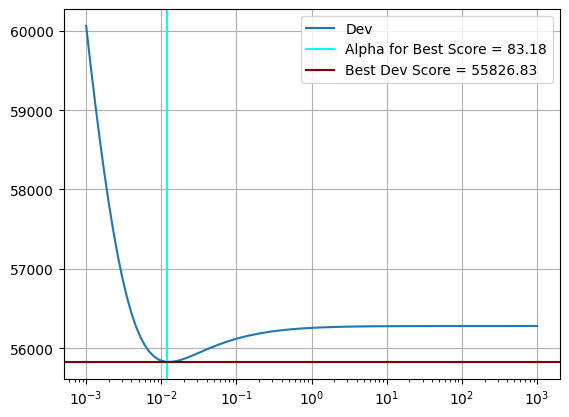

In [23]:
score_plot(grid_search_holdout, alpha_list)

# Cross Validation with K-Fold

In [30]:
param_grid = {"regression__alpha": alpha_list}
grid_search_kfold = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
).fit(df_zscores[numeric_features], df_zscores[target_feature])

In [31]:
best_estimator_kfold = grid_search_kfold.best_estimator_
dev_rmse_kfold = root_mean_squared_error(y_dev, best_estimator_kfold.predict(X_dev))
dev_rmse_kfold

54758.84966861962

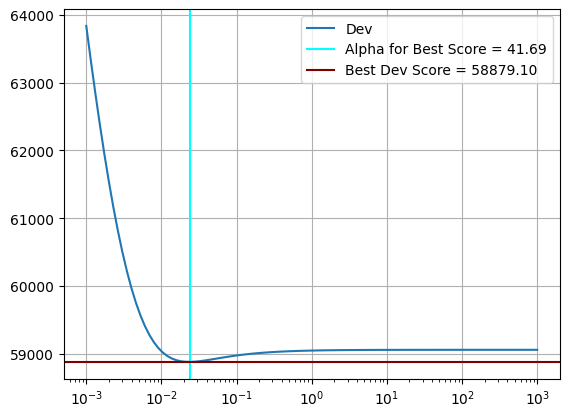

In [20]:
score_plot(grid_search_kfold, alpha_list)

# Cross Validation with Leave One Out

In [34]:
param_grid = {"regression__alpha": alpha_list}
grid_search_loo = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=len(df_zscores),
).fit(df_zscores[numeric_features], df_zscores[target_feature])

In [32]:
best_estimator_loo = grid_search_loo.best_estimator_
dev_rmse_loo = root_mean_squared_error(y_dev, best_estimator_loo.predict(X_dev))
dev_rmse_loo

NameError: name 'grid_search_loo' is not defined

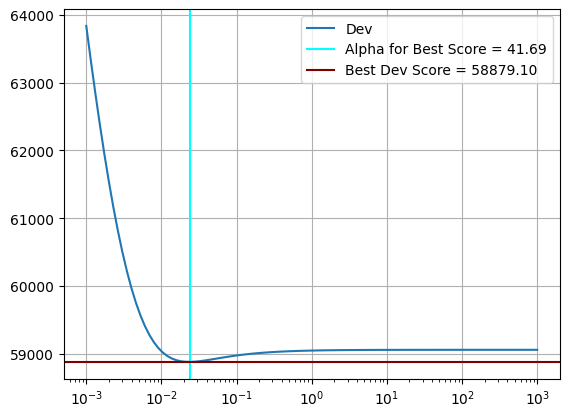

In [ ]:
score_plot(grid_search_loo, alpha_list)

# Comparisons

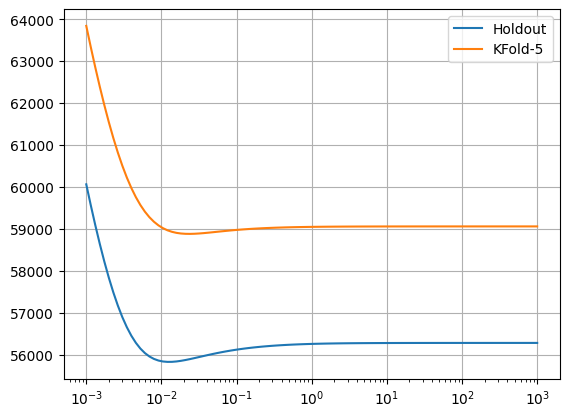

In [26]:
# Overplot scores per run
plt.plot(
    1.0 / alpha_list,
    -grid_search_holdout.cv_results_["mean_test_score"],
    label="Holdout",
)

plt.plot(
    1.0 / alpha_list,
    -grid_search_kfold_5.cv_results_["mean_test_score"],
    label="KFold-5",
)

plt.xscale("log")
plt.legend()

# Conclusions